In [2]:
!pip install pyreadr

  Using cached pyreadr-0.4.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (363 kB)


In [4]:
!pip install lifelines

     |████████████████████████████████| 348 kB 9.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 55 kB 4.9 MB/s             
  Preparing metadata (setup.py) ... done
  Using cached future-0.18.2.tar.gz (829 kB)
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 81 kB 10.8 MB/s            
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47988 sha256=e39a0bc2d143851f0fc97ebcac949a879f80ec6e4c41d6f7041198e5334b6145
  Stored in directory: /home/jovyan/.cache/pip/wheels/b6/86/a9/2c2d40e3c7d837ca251d7cb66f06a283c8679fa17421e8ddeb
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=5cc0c52aeffca009e00c24327bc2719e5b6a39ba343c10641fbd5b04220fdb91
  Stored in directory: /home/jovyan/.cache/pip/wheels/a8/03/64/8557323821d25118c3a2dc1646996f7a962a8970d4b7d22473
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha

In [35]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from lifelines.fitters.coxph_fitter import CoxPHFitter

In [36]:
train_data = pyreadr.read_r('data_train.rds')[None]

In [37]:
NUM_GENES = 10

## 1. Data exploration

In [38]:
train_data.head()

,age,sex,histology,os_months,dead,dead_at_censor_months,MIR107,CT45A10,ATP10B,TMEM134,...,cg00055848,cg17124408,cg01751470,cg03209541,cg17257676,cg09776513,cg00417165,cg10691006,cg26870192,cg18317492
rownames,,,,,,,,,,,,,,,,,,,,,
TEST001,35.20,M,TCGA-LGG,10.57,False,NaN,0.0,2.662403,7.912224,11.069677,...,0.029023,0.600187,0.026170,0.011748,0.027551,0.009141,0.021541,0.186937,0.053800,0.986071
TEST002,24.67,F,TCGA-LGG,23.80,False,NaN,0.0,0.000000,8.511476,10.496681,...,0.045516,0.729045,0.026045,0.013891,0.026960,0.009637,0.041495,0.162778,0.190160,0.985341
TEST003,48.39,M,TCGA-LGG,14.77,False,NaN,0.0,0.000000,9.390933,10.404901,...,0.067580,0.614413,0.022115,0.013550,0.025861,0.009314,0.043065,0.078004,0.617174,0.979573
TEST004,34.46,M,TCGA-LGG,0.23,False,NaN,0.0,1.242057,7.994106,10.464319,...,0.182457,0.724407,0.019426,0.012849,0.023996,0.007946,0.039243,0.447242,0.848898,0.977869
TEST005,38.77,F,TCGA-LGG,9.73,False,NaN,0.0,0.000000,8.885382,10.829981,...,0.035019,0.844752,0.029215,0.014706,0.035278,0.010482,0.034728,0.126422,0.169455,0.984962


In [39]:
print(np.unique(train_data.sex))
print(np.unique(train_data.histology))

train_data.sex = (train_data.sex == 'F')
train_data = train_data.drop(columns=['histology'])

['F' 'M']
['TCGA-LGG']


In [40]:
train_patient_data = train_data.loc[:, ['age', 'sex']]
train_rna_data = train_data.iloc[:, -2000:-1000]
train_meth_data = train_data.iloc[:, -1000:]

### 1.1. RNA data

In [41]:
train_rna_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, TEST001 to TEST408
Columns: 1000 entries, MIR107 to ZNF704
dtypes: float64(1000)
memory usage: 3.1+ MB


In [42]:
np.sum(np.sum(train_rna_data.isna()))

0

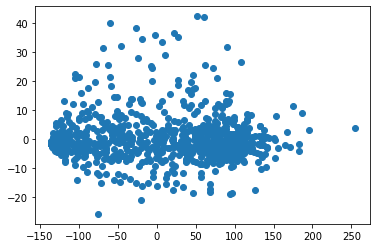

In [43]:
pca = PCA(2)
pca.fit(train_rna_data.T)
plt.scatter(*pca.transform(train_rna_data.T).T)

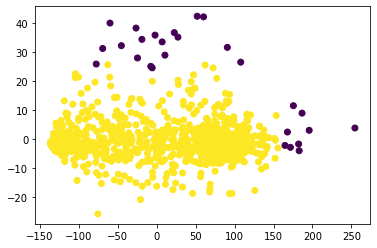

In [44]:
clustering = DBSCAN(eps=15, min_samples=25).fit(pca.transform(train_rna_data.T))
plt.scatter(*pca.transform(train_rna_data.T).T, c=clustering.labels_)
train_rna_columns = clustering.labels_>-1
train_rna_data = train_rna_data.loc[:, train_rna_columns]

In [45]:
pca_rna = PCA(NUM_GENES)
train_rna_data = pca_rna.fit_transform(train_rna_data)

In [46]:
rna_scaler = preprocessing.StandardScaler().fit(train_rna_data)
train_rna_data = rna_scaler.transform(train_rna_data)

### 1.2. Methylation data

In [47]:
train_meth_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, TEST001 to TEST408
Columns: 1000 entries, cg06971096 to cg18317492
dtypes: float64(1000)
memory usage: 3.1+ MB


In [48]:
np.sum(np.sum(train_meth_data.isna()))

0

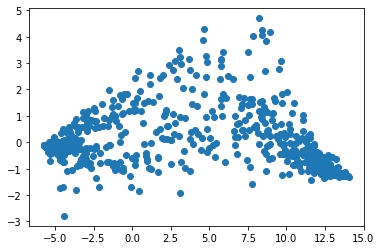

In [49]:
pca = PCA(2)
pca.fit(train_meth_data.T)
plt.scatter(*pca.transform(train_meth_data.T).T)

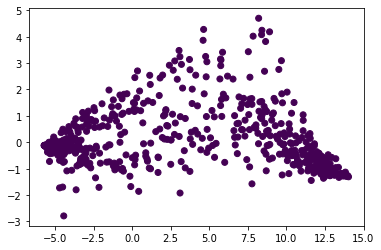

In [50]:
clustering = DBSCAN(eps=10, min_samples=25).fit(pca.transform(train_meth_data.T))
plt.scatter(*pca.transform(train_meth_data.T).T, c=clustering.labels_)
train_meth_columns = clustering.labels_>-1
train_meth_data = train_meth_data.loc[:, train_meth_columns]

In [51]:
pca_meth = PCA(NUM_GENES)
train_meth_data = pca_meth.fit_transform(train_meth_data)

In [52]:
meth_scaler = preprocessing.StandardScaler().fit(train_meth_data)
train_meth_data = meth_scaler.transform(train_meth_data)

In [53]:
train_patient_data.iloc[:, 0] = train_patient_data.to_numpy()[:, 0] / np.max(train_patient_data.to_numpy()[:, 0])

In [54]:
print(train_patient_data.shape)
print(train_rna_data.shape)
print(train_meth_data.shape)

(408, 2)
(408, 10)
(408, 10)


In [55]:
train_rna_data = pd.DataFrame(train_rna_data, columns=[f'rna_{i}' for i in range(train_rna_data.shape[1])])
train_meth_data = pd.DataFrame(train_meth_data, columns=[f'meth_{i}' for i in range(train_meth_data.shape[1])])
train_patient_data = train_patient_data.reset_index()

In [56]:
train_x = pd.concat([train_patient_data, train_rna_data, train_meth_data, train_data.loc[:, ['os_months', 'dead']].reset_index()], axis=1, ignore_index=False).drop(columns=['rownames'])

In [57]:
train_x, val_x= train_test_split(train_x, train_size=0.7)

## 2. Model

In [58]:
train_x

,age,sex,rna_0,rna_1,rna_2,rna_3,rna_4,rna_5,rna_6,rna_7,...,meth_2,meth_3,meth_4,meth_5,meth_6,meth_7,meth_8,meth_9,os_months,dead
210,0.361819,False,0.208513,-0.280608,-1.668480,0.575487,0.042682,-1.211594,-0.643180,0.481223,...,-0.528559,-0.773027,-0.063867,0.002381,1.088396,-0.602421,0.580696,1.423902,41.40,True
227,0.514013,True,1.480426,-0.878046,-1.678460,2.981747,0.251769,1.044306,0.937607,-0.563596,...,0.519211,-0.662804,0.336786,-0.943317,0.574014,-1.561432,0.280392,0.625923,20.30,False
175,0.262463,False,-0.508996,-1.304639,0.001803,-1.302004,0.924090,0.317242,-0.688392,-0.539895,...,0.951112,-1.796771,-0.075716,0.562526,0.285538,0.888306,-0.970845,0.049571,47.60,False
275,0.66816,False,-0.677295,0.381518,-0.093087,0.669003,-0.826440,0.063266,-0.946832,-0.278156,...,0.474634,1.785064,1.444104,0.389795,0.499873,-0.373611,-0.615845,0.330140,76.30,False
42,0.419711,True,-0.485560,0.215598,-0.317173,-0.142413,1.318994,-0.509049,1.406174,-0.036836,...,0.988675,-0.756479,0.149548,0.033520,0.968170,0.385034,0.009594,-1.275835,11.40,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.398231,False,-0.167544,0.092869,-0.157302,-1.541458,-0.104714,1.115344,-0.807810,-0.774330,...,0.064357,0.374734,-0.428773,-0.796163,0.913735,-1.023373,-0.499237,0.899415,81.10,True
128,0.526533,False,-0.144167,0.999351,-0.464433,0.221350,0.180706,0.348233,-1.286604,-0.016203,...,-0.437425,0.694693,1.359066,-0.851910,-0.590657,0.730951,0.469882,0.698108,31.10,False
214,0.532162,True,-1.165093,0.054710,0.061484,1.105007,-1.444734,-0.745216,1.015023,0.812622,...,-1.045011,0.450990,-0.128591,0.383785,0.621241,1.288581,-0.869229,0.402839,31.30,False
105,0.413623,False,0.284891,2.385622,0.056190,0.062825,0.596175,-0.645875,-1.104572,0.238922,...,-1.490508,0.576553,0.313603,1.451680,1.142556,0.018260,-0.451559,0.502741,39.63,False


In [59]:
cph = CoxPHFitter()
cph.fit(train_x, 'os_months', 'dead')
cph.predict(train_x)

AttributeError: CoxPHFitter has no attribute 'predict'

In [60]:
cph.score(train_x, 'concordance_index')

0.8538950183884988

In [61]:
sum(cph.predict_median(train_x) > 36)

241

## 3. Test set prediction

In [62]:
test_data = pyreadr.read_r('data_test.rds')[None]

In [63]:
test_data.sex = (test_data.sex == 'F')
test_data = test_data.drop(columns=['histology'])

In [64]:
test_patient_data = test_data.loc[:, ['age', 'sex']]
test_rna_data = test_data.iloc[:, -2000:-1000]
test_meth_data = test_data.iloc[:, -1000:]

In [65]:
test_rna_data = test_rna_data.loc[:, train_rna_columns]
test_meth_data = test_meth_data.loc[:, train_meth_columns]

In [ ]:
test_rna_data = pca_rna.transform(test_rna_data)
test_meth_data = pca_meth.fit_transform(test_meth_data)

In [32]:
test_rna_data = rna_scaler.transform(test_rna_data)
test_meth_data = meth_scaler.transform(test_meth_data)

In [33]:
test_rna_data = pd.DataFrame(test_rna_data, columns=[f'rna_{i}' for i in range(test_rna_data.shape[1])])
test_meth_data = pd.DataFrame(test_meth_data, columns=[f'meth_{i}' for i in range(test_meth_data.shape[1])])
test_patient_data = test_patient_data.reset_index()

In [34]:
test_x = pd.concat([test_patient_data, test_rna_data, test_meth_data, test_data.loc[:, ['os_months', 'dead']].reset_index()], axis=1, ignore_index=False).drop(columns=['rownames'])


In [49]:
np.sum(cph.predict_median(test_x) > 36)

0

In [50]:
cph.predict_median(train_x) > 36

88     True
317    True
55     True
161    True
370    True
       ... 
229    True
348    True
0      True
320    True
228    True
Name: 0.5, Length: 285, dtype: bool